Importing necessary libraries

In [4]:
from selenium import webdriver
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Using Selenium to extract HTML from URL

In [ ]:
driver = webdriver.Chrome('C:\Luuk\chromedriver\chromedriver.exe')
driver.get('https://nl.wikipedia.org/wiki/Lijst_van_Radio_2-Top_2000%27s')
page_source = driver.page_source
driver.close()

Using BeautifulSoup to find table in HTML and Pandas to extract table from HTML

In [109]:
soup = BeautifulSoup(page_source, 'html.parser')

table = soup.find("table",{"class":"wikitable sortable jquery-tablesorter"})

df = pd.read_html(str(table))[0]

Extracting dataframe to csv file and subsequently importing csv file for quick access

In [110]:
df.to_csv('C:/Luuk/Visual Studio/top2000.csv', sep=';')

In [5]:
df = pd.read_csv('C:/Luuk/Visual Studio/top2000.csv', sep=';', index_col=0)
df.head()

,Artiest,Titel,Jaar,HP,99,00,01,02,03,04,...,12,13,14,15,16,17,18,19,20,21
0,Queen,Bohemian Rhapsody,1975,1,1,1,1,1,1,1,...,1,1,2,2,1,1,1,1,2,1
1,Danny Vera,Roller Coaster,2019,1,×,×,×,×,×,×,...,×,×,×,×,×,×,×,4,1,2
2,Procol Harum,A Whiter Shade of Pale,1967,3,10,18,23,20,22,28,...,61,83,98,105,119,117,153,162,153,3
3,Eagles,Hotel California,1977,1,2,4,3,3,2,2,...,2,2,1,3,2,2,2,2,3,4
4,Billy Joel,Piano Man,1974,3,121,83,57,58,60,66,...,36,18,7,6,4,4,3,3,4,5


Cleaning the data

In [6]:
df.drop('HP', axis=1, inplace=True)
df.replace('×', np.nan, inplace=True)
df.replace('—', np.nan, inplace=True)

Define function to easily access yearly rankings from Top 2000

In [7]:
def getYear(year):
    df_year = df[['Artiest', 'Titel', 'Jaar', year]].dropna()
    df_year = df_year.astype({year: 'int64'})
    df_year = df_year[['Artiest', 'Titel', 'Jaar', year]].sort_values(year).reset_index(drop=True)
    return df_year

Define function to plot contribution by top 10 artists per year

In [15]:
def plotContributionPerYear(df):
    df = df.value_counts(['Artiest']).reset_index(name='Counts')[:10].sort_values('Counts')
    plt.style.use('ggplot')
    cmap = plt.get_cmap('tab10')
    hbars = plt.barh(df['Artiest'], df['Counts'], color=cmap.colors)
    plt.title('Aantal nummers in de Top 2000 van artiesten in het jaar 2021 (top 10)')
    plt.yticks(fontsize=12)
    plt.bar_label(hbars, padding=-20, fontsize=12)
    plt.savefig('top10top2000.png', dpi=300, bbox_inches='tight')
    return plt.show()

Plot contribution by top 10 artist in the year 2021

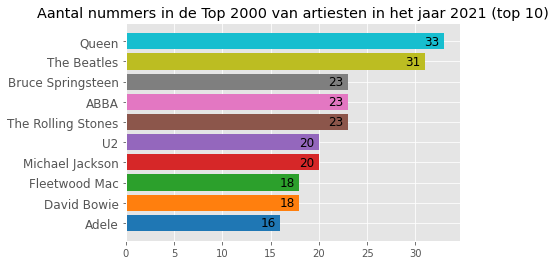

In [59]:
plotContributionPerYear(getYear('21'))

Define function to compare top artists results from one year to another

In [19]:
def plotContributionPerTwoYears(*df):
    df0 = df[0].value_counts(['Artiest'])[:10].reset_index(name='Counts').sort_values('Counts')
    df1 = df[1].value_counts(['Artiest']).reset_index(name='Counts').sort_values('Counts')
    df_merged = df0.merge(df1, how='inner', on='Artiest')
    
    y = df_merged['Artiest']
    y_axis = np.arange(0, len(y)*2, 2)
    width = 0.8

    plt.style.use('ggplot')

    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(8)

    hbars1 = plt.barh(y_axis + 0.4, df_merged['Counts_x'], width, label='2021', color='tab:blue')
    hbars2 = plt.barh(y_axis - 0.4, df_merged['Counts_y'], width, label='2001', color='tab:red')

    plt.yticks(y_axis, y, fontsize=14)
    plt.title('Aantal nummers in de top 2000 per artiest (2021-2001)')
    plt.bar_label(hbars1, padding=-22, fontsize=14, color='white')
    plt.bar_label(hbars2, padding=-22, fontsize=14, color='white')
    plt.legend(fontsize=20)
    
    plt.savefig('top10top2year.png', dpi=300, bbox_inches='tight')
    return plt.show()

Plot contribution by top artist results in 2021 compared to 2001

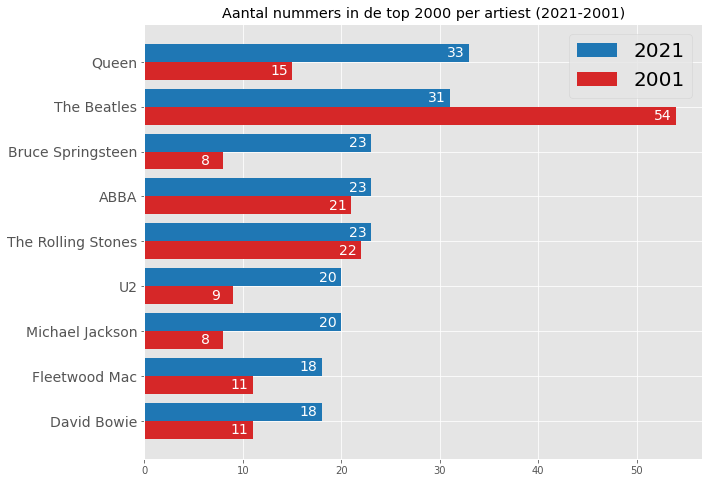

In [62]:
plotContributionPerTwoYears(getYear('21'), getYear('01'))

Preparing data for showing contribution over time

In [63]:
col_list = list(df)[5:]
df21 = getYear('21')
df_years = df21.value_counts(['Artiest'])[:6].reset_index(name='21').sort_values('21')
for year in col_list:
    df_year = getYear(year)
    df_year = df_year.value_counts(['Artiest']).reset_index(name=year).sort_values(year)

    df_temp = df_years.merge(df_year, how='left', on='Artiest')

    df_years = df_temp

df_years.drop('21_x', axis=1, inplace=True)
df_years.rename(columns={'21_y': '21', 'Artiest': 'Years'}, inplace=True)

df_years.set_index('Years', inplace=True)
df_years = df_years.transpose()

df_years.head()

Years,Michael Jackson,The Rolling Stones,ABBA,Bruce Springsteen,The Beatles,Queen
01,8,22,21,8,54,15
02,8,31,23,8,54,16
03,9,35,21,8,54,16
04,9,37,24,8,55,16
05,9,34,26,8,55,19


Plotting data to show contribution over time for top 6 artist with the highest contribution in the year 2021

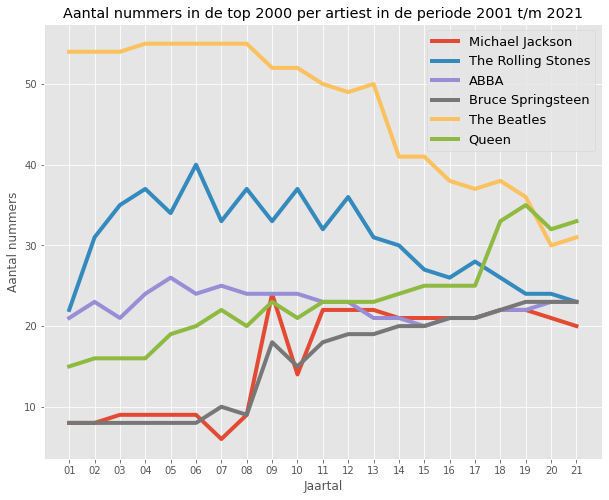

In [66]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

plt.style.use('ggplot')

for artist in list(df_years):
    plt.plot(col_list, df_years[artist], label=artist, linewidth=4)

plt.legend(prop={'size': 13})
plt.title('Aantal nummers in de top 2000 per artiest in de periode 2001 t/m 2021')
plt.xlabel('Jaartal')
plt.ylabel('Aantal nummers')
plt.savefig('top6year01-21.png', dpi=300, bbox_inches='tight')
plt.show()